<a href="https://colab.research.google.com/github/Padawanh/WIMyD/blob/main/Reinforcement_Learning_Multi_Armed_Bandit_UCB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Multi-Armed Bandit (MaB) com upper confidence bound (UCB)

O algoritmo de aprendizado por reforço Multi-Armed Bandit (MaB) é uma técnica de aprendizado de máquina que busca encontrar a melhor opção entre várias alternativas, levando em conta a recompensa e o custo de cada uma. O nome vem de uma analogia com um cenário em que um apostador tem que escolher entre várias máquinas caça-níqueis (ou bandidos de um braço só) em um cassino, cada uma com uma probabilidade desconhecida de dar um prêmio. O desafio é balancear a ***exploração*** das máquinas para aprender sobre elas e a ***explotação*** (escolha) da máquina que parece ser a mais lucrativa.

Existem diferentes estratégias para implementar o algoritmo MaB, como epsilon-greedy, upper confidence bound (UCB) ou Thompson sampling. Cada uma delas tem vantagens e desvantagens em termos de complexidade, convergência e eficiência.A seguir, explicaremos mais sobre a estratégia UCB.



In [1]:
import math
import random
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

plt.style.use('seaborn')

#Configurações de visualização do pandas
pd.options.display.precision = 10
pd.options.display.float_format = "{:.2f}".format
pd.options.display.max_info_columns = 200
pd.set_option('display.width', 2500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.options.display.max_colwidth = 100

<ipython-input-1-5b0a0ee46796>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Para fins didáticos eu tenho os seguintes dados que representam a quantidade de cliques de post por hora em um período de 31 dias. Os posts 3 é o melhor, seguido do post 1, mas é importante ter consciência que no momento que o algoritmo processa isso ela não tem noção do cenário geral de qual vai ser o melhor post (que fica evidente para gente), mas com o decorrer do tempo ele tende a convergir para o melhor.

,p1,p2,p3,p4,p5
count,168.00,168.00,168.00,168.00,168.00
mean,74.46,43.71,76.73,50.79,56.69
std,1.45,1.07,1.77,0.95,1.01
min,70.41,41.09,71.61,48.38,53.76
25%,73.48,43.07,75.53,50.14,56.03
50%,74.49,43.68,76.66,50.81,56.62
75%,75.40,44.35,77.98,51.41,57.36
max,77.92,47.03,81.62,53.24,59.14


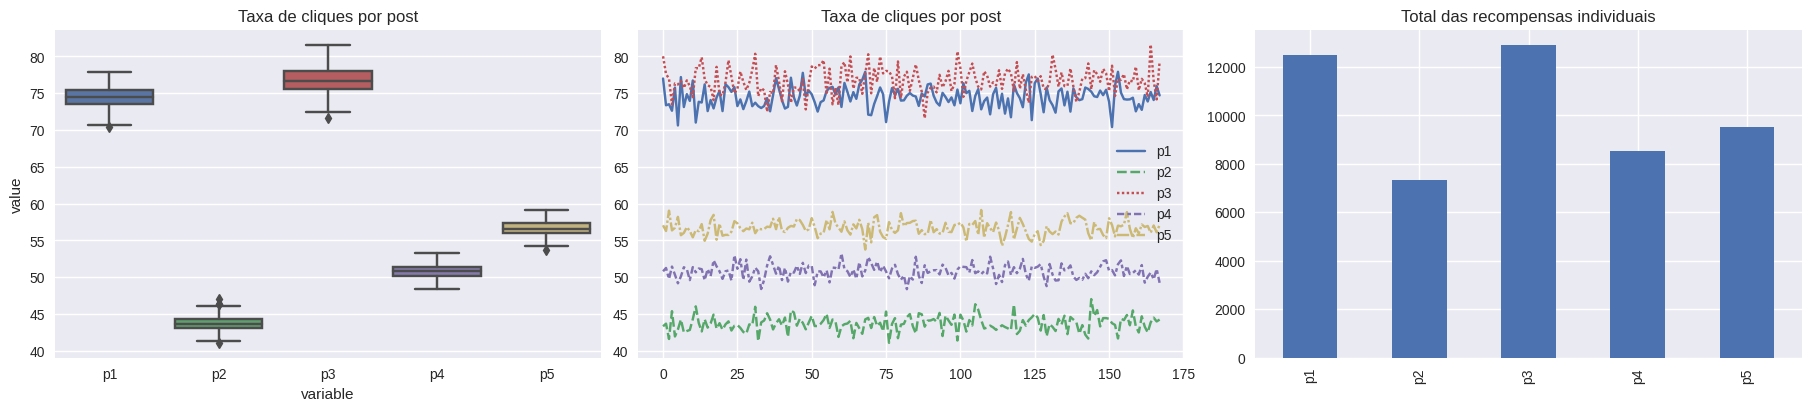

In [2]:
# Gera dados
dias = 7
userSize = 24*dias

user = list(range(0, userSize))

# Esses são os braços com as suas respectivas recompensas, podemos imaginar isso como conteúdos a serem recomendados e quantos cliques cada um teve
Posts = {}
N_Posts = 5
for i in range(1, N_Posts + 1):
    avg = np.random.RandomState(i).normal(50, 15, size=1).clip(40, 90)
    devian = np.random.RandomState(i).normal(size=1).clip(1, 45)
    Posts["p" + str(i)] = np.random.RandomState(i).normal(avg, devian, size=userSize).clip(0, 100)

posts_rates_normais = pd.DataFrame(Posts)

# Exibe estatísticas descritivas dos dados
display(posts_rates_normais.describe())

# Cria gráficos para visualizar os dados
fig, (ax1, ax2 , ax3) = plt.subplots(ncols=3, constrained_layout=True, figsize=(18, 4))
ax1.set_title("Taxa de cliques por post")
sns.boxplot(x="variable", y="value", data=pd.melt(posts_rates_normais), ax=ax1)
ax2.set_title("Taxa de cliques por post")
sns.lineplot(data=posts_rates_normais, ax=ax2)
ax3 = posts_rates_normais.sum().plot(kind='bar',title='Total das recompensas individuais')
fig.show()



### The Upper Confidence Bound

A estratégia UCB se baseia na ideia de que cada opção de ação tem um intervalo de confiança associado à sua estimativa de recompensa, uma boa representação disso são os box-plot que vimos agora pouco, porém essas distribuições não são conhecidas de inicio e depende do número de vezes que cada opção foi escolhida ao longo do tempo entendermos suas reais distribuições. Quanto mais vezes uma opção é escolhida, menor é o intervalo de confiança e mais precisa é a estimativa e evita que façamos uma escolha baseada em uma quantidade pequena de observações. A estratégia UCB consiste em escolher sempre a opção que tem o maior limite superior do intervalo de confiança, ou seja, a opção que tem o maior potencial de recompensa, e ele também pondera explorar um pouco opções que foram pouco escolhidas, dando uma segunda chance para que elas se provem. Isso garante que as opções com estimativas incertas sejam ***exploradas*** e as opções com estimativas promissoras sejam ***explotadas***.

A vantagem da estratégia UCB é que ela é simples, eficiente e teoricamente ótima, ou seja, ela minimiza o arrependimento esperado do agente (o algoritmo). O arrependimento é a diferença entre a recompensa ótima (a escolha sempre da melhor opção) e a recompensa obtida pelo agente. A desvantagem da estratégia UCB é que ela requer conhecer o número total de iterações do algoritmo e assumir que as recompensas seguem **distribuições estacionárias e limitadas**. Vou deixar aqui dois links que ajudam bem a compreender [Multi-Armed Bandit](https://www.youtube.com/watch?v=e3L4VocZnnQ) e o [UCB](https://www.youtube.com/watch?v=FgmMK6RPU1c&t=1s).

Abaixo temos a formula do Multi-Armed Bandit UCB;



<img src="https://miro.medium.com/v2/resize:fit:828/format:webp/1*f_XHSm6ZWZdIrMDyyG41Uw.png" width="600">

t = o tempo (ou rodada) em que estamos atualmente\
a = ação selecionada (no nosso caso o post escolhido)\
Nt(a) = número de vezes que a ação a foi selecionada antes do tempo t\
Qt(a) = recompensa média da ação a antes do tempo t\
c = um número maior que 0 que controla o grau de exploração\

In [3]:
# @title Função UCB
def ucb(df, c):
    """
    Função que implementa o algoritmo Upper Confidence Bound (UCB) para escolha de ações em um histórico de recompensas por escolha.

    Parâmetros
    ----------
    df : pandas.DataFrame
        DataFrame contendo os dados das recompensas das ações.

    c : float
        Parâmetro que controla o grau de exploração. Um número maior que 0 aumenta o grau de exploração.

    Retornos
    -------
    history_selected : pandas.DataFrame
        DataFrame contendo o histórico das ações selecionadas pelo algoritmo UCB.
    """

    # Inicializa variáveis
    N = len(df.index)  # Rodadas
    n_escolhas = len(df.columns)  # número de mensagens possíveis
    Qt_a = 0  # Qt(a) = recompensa média da ação a antes do tempo t , começa com 0

    # Número de vezes que a ação a foi selecionada antes de T,se Nt(a) = 0, então a é considerada uma ação maximizadora.
    Nt_a = np.zeros(n_escolhas)

    sum_rewards = np.zeros(n_escolhas)  # soma cumulativa da recompensa para uma mensagem específica

    # variáveis auxiliares para realizar análise
    hist_t = list()  # armazena o log natural de cada rodada
    hist_achieved_rewards = list()  # armazena o histórico das recompensas cumulativas ESCOLHIDAS pelo UCB
    hist_choice =  list()   # armazena o histórico de escolhas

    # loop através do número de rodadas # t = tempo
    history_selected = {i: [0] for i in range(len(df.columns))}
    for t in range(0, N):
        UCB_Values = np.zeros(n_escolhas)  # array contendo os valores ucb. escolhemos o máximo
        action_selected = 0
        for a in range(0, n_escolhas):
            if (Nt_a[a] > 0):
                ln_t = math.log(t)  # log natural de t
                hist_t.append(ln_t)  # para plotar o log natural de t

                # calcula o UCB
                Qt_a = sum_rewards[a] / Nt_a[a]
                ucb_value = Qt_a + c * (ln_t / Nt_a[a])
                UCB_Values[a] = ucb_value

            # se isso for igual a zero, escolha como o máximo. Não pode dividir por negativo
            elif (Nt_a[a] == 0):
                UCB_Values[a] = 1e500  # torna o valor grande

        # seleciona o valor UCB máximo
        action_selected = np.argmax(UCB_Values)

        # atualiza valores a partir da rodada t
        Nt_a[action_selected] += 1
        reward = df.values[t, action_selected]

        hist_achieved_rewards.append(reward)
        hist_choice.append(action_selected)
        sum_rewards[action_selected] += reward
        for i in range(0, n_escolhas):
            if i == action_selected:
                history_selected[i].append(max(history_selected[i]) + 1)
            else:
                history_selected[i].append(max(history_selected[i]))

    history_selected = pd.DataFrame(history_selected)
    history_selected.columns = df.columns
    hist_choice = [ "p"+str(i+1) for i in hist_choice]
    hist_choice_rewards = pd.DataFrame({"Choice":hist_choice,"reward":hist_achieved_rewards})

    return history_selected  , hist_choice_rewards

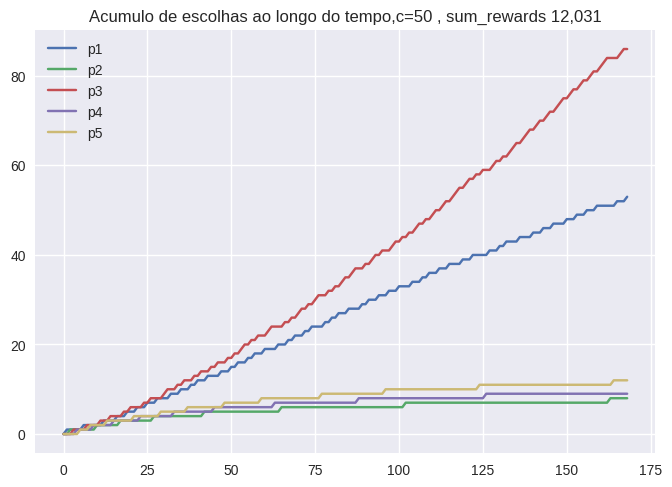

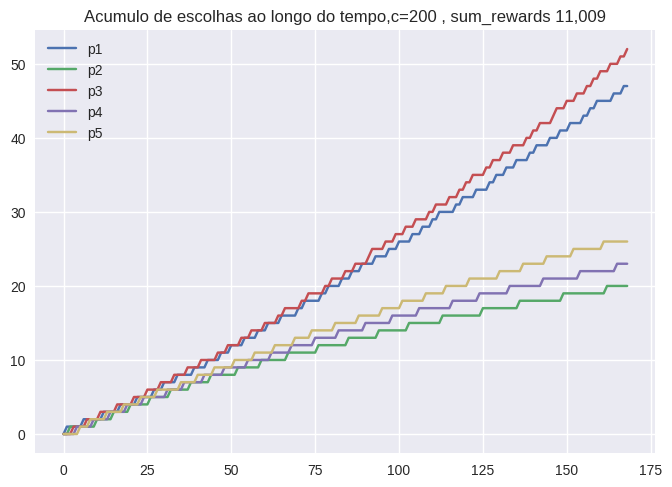

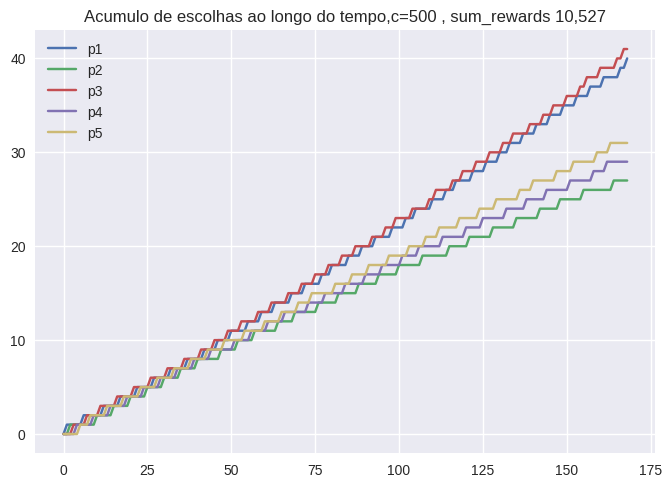

In [4]:
for i in [50,200,500]:
  historySelected ,hist_choice_rewards = ucb(posts_rates_normais, c=i)
  historySelected.plot()
  plt.title(f"Acumulo de escolhas ao longo do tempo,c={i} , sum_rewards {hist_choice_rewards['reward'].sum():,.0f}")
  plt.show()
# display(historySelected)

In [5]:
# @title Funções escolha aleatoria e melhor escolhas

def escolher_coluna_aleatoriamente(df):
    # Crie uma lista para armazenar os DataFrames temporários
    output_frames = []

    # Para cada linha na tabela de entrada
    for index, row in df.iterrows():
        # Escolha aleatoriamente uma coluna
        coluna_escolhida = random.choice(df.columns)

        # Obtenha o valor da coluna escolhida
        valor = row[coluna_escolhida]

        # Crie um DataFrame temporário para esta linha
        temp_df = pd.DataFrame({"Choice": [coluna_escolhida], "reward": [valor]})

        # Adicione o DataFrame temporário à lista
        output_frames.append(temp_df)

    # Concatene todos os DataFrames temporários em um único DataFrame de output
    output_table = pd.concat(output_frames, ignore_index=True)

    return output_table

def escolher_coluna_maior_valor(df):
    # Crie uma lista para armazenar os DataFrames temporários
    output_frames = []

    # Para cada linha na tabela de entrada
    for index, row in df.iterrows():
        # Encontre a coluna com o maior valor na linha
        coluna_maior_valor = row.idxmax()

        # Obtenha o valor da coluna com o maior valor
        valor = row[coluna_maior_valor]

        # Crie um DataFrame temporário para esta linha
        temp_df = pd.DataFrame({"Choice": [coluna_maior_valor], "reward": [valor]})

        # Adicione o DataFrame temporário à lista
        output_frames.append(temp_df)

    # Concatene todos os DataFrames temporários em um único DataFrame de output
    output_table = pd.concat(output_frames, ignore_index=True)

    return output_table


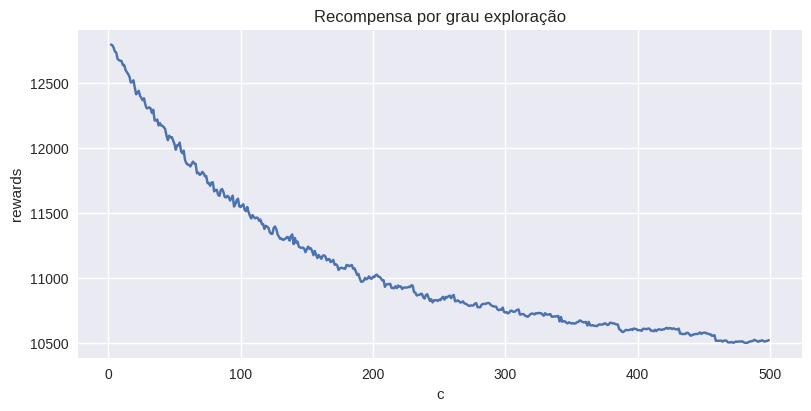

In [6]:
rewards = list()
range_table = range(2,500)
for i in range_table:
  _ ,ucb_choice = ucb(posts_rates_normais, c=i)
  rewards.append(ucb_choice['reward'].sum())

optimize_exploration = pd.DataFrame({"c":range_table ,"rewards":rewards})

fig2, ax  = plt.subplots(ncols=1, constrained_layout=True, figsize=(8, 4))
ax = sns.lineplot(data=optimize_exploration , x="c" , y="rewards")
ax.set(title="Recompensa por grau exploração")
fig2.show()


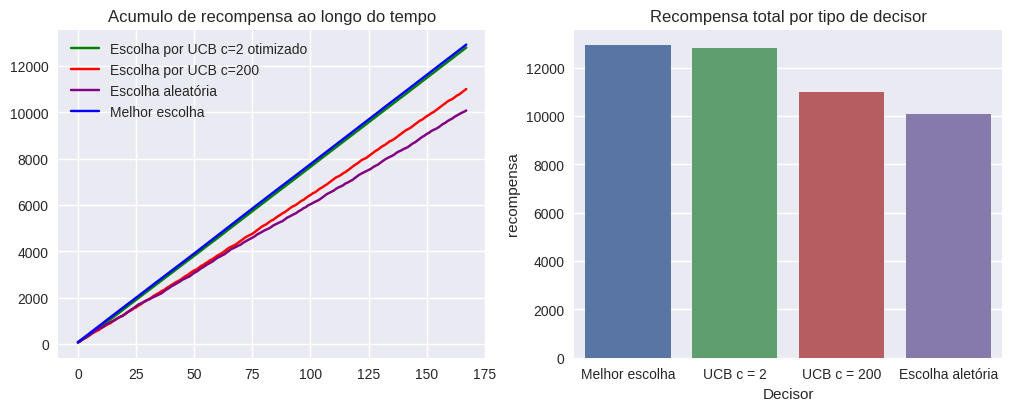

In [7]:
c = optimize_exploration[optimize_exploration['rewards'] == optimize_exploration['rewards'].max()]["c"].values[0]
_ ,ucb_choice = ucb(posts_rates_normais, c=c)
ucb_choice['cumulative_reward'] = ucb_choice['reward'].cumsum()
ucb_choice_reward  = ucb_choice['reward'].sum()


N = 200
_ ,ucb_choiceN = ucb(posts_rates_normais, c=N)
ucb_choiceN['cumulative_reward'] = ucb_choiceN['reward'].cumsum()
ucb_choiceN_reward  = ucb_choiceN['reward'].sum()


ramdom_choice = escolher_coluna_aleatoriamente(posts_rates_normais)
ramdom_choice['cumulative_reward'] = ramdom_choice['reward'].cumsum()
ramdom_choice_reward  = ramdom_choice['reward'].sum()

best_choice = escolher_coluna_maior_valor(posts_rates_normais)
best_choice['cumulative_reward'] = best_choice['reward'].cumsum()
best_choice_reward  = best_choice['reward'].sum()

recompensas = pd.DataFrame({"Decisor":[f"UCB c = {c}", f"UCB c = {N}", "Escolha aletória","Melhor escolha"],
                    "recompensa":[ucb_choice_reward ,ucb_choiceN_reward , ramdom_choice_reward,best_choice_reward]}).sort_values("recompensa",ascending=False)

# last_best_choice = escolher_coluna_maior_coluna_anterior(posts_rates_normais)
# last_best_choice['cumulative_reward'] = last_best_choice['reward'].cumsum()
fig, (ax1, ax2) = plt.subplots(ncols=2, constrained_layout=True, figsize=(10, 4))

ucb_choice['cumulative_reward'].plot(label=f"Escolha por UCB c={c} otimizado", ax=ax1, color="green")
ucb_choiceN['cumulative_reward'].plot(label=f"Escolha por UCB c={N}", ax=ax1 , color="red")
ramdom_choice['cumulative_reward'].plot(label="Escolha aleatória", ax=ax1 , color="purple")
best_choice['cumulative_reward'].plot(label="Melhor escolha", ax=ax1 , color="blue")
# last_best_choice['cumulative_reward'].plot(label="Último melhor")
ax1.set(title=f"Acumulo de recompensa ao longo do tempo")
ax1.legend()

ax2 = sns.barplot(data=recompensas , x="Decisor" , y="recompensa")
ax2.set(title=f"Recompensa total por tipo de decisor")
fig.show()

In [8]:
(ucb_choice_reward - best_choice_reward) / best_choice_reward

-0.010068053505358747

In [9]:
(ramdom_choice_reward -best_choice_reward) / best_choice_reward

-0.22008951066452292

In [10]:
recompensas

,Decisor,recompensa
3,Melhor escolha,12927.61
0,UCB c = 2,12797.45
1,UCB c = 200,11009.18
2,Escolha aletória,10082.38



O algoritmo de Multi-Armed Bandit UCB é um algoritmo de aprendizado por reforço que visa maximizar a recompensa ao longo do tempo. Para aplicar o algoritmo UCB, você deve levar em consideração as seguintes premissas:

1. **Exploração vs. explotação**: O algoritmo UCB tenta encontrar um equilíbrio entre explorar novas opções e explorar opções que já foram bem-sucedidas no passado. Isso é importante porque, se você explorar apenas novas opções, poderá perder oportunidades valiosas de recompensa. Por outro lado, se você explorar apenas opções que já foram bem-sucedidas no passado, poderá ficar preso em uma solução sub-ótima.

2. **Recompensas estocásticas**: O algoritmo UCB assume que as recompensas são estocásticas, o que significa que embora siga algum padrão, não tem um resultado previsível devido à influência de elementos aleatórios. Isso é importante porque, se as recompensas fossem determinísticas, seria fácil encontrar a melhor opção simplesmente escolhendo a opção com a maior recompensa.

3. **Conhecimento prévio limitado**: O algoritmo UCB assume que você tem conhecimento prévio limitado sobre as recompensas associadas a cada opção. Isso é importante porque, se você tivesse conhecimento completo sobre as recompensas associadas a cada opção, seria fácil encontrar a melhor opção simplesmente escolhendo a opção com a maior recompensa.

#Bônus

Como citado anteriormente o UCB assume que temos distribuições estacionárias e limitadas e por isso o conjunto de dados anterior era estacionário. Contudo a quantidade de cliques de post por hora em uma cenário real iria variar com o decorrer do tempo, subindo em um momento, decaindo em outro e outro post tomaria o seu lugar em destaque. Por curiosidade testei como ele desempenharia nesse cenário mais semelhante ao real. De inicio as nossas distribuições seriam algo mais parecido com o que temos abaixo. Observe que os posts 2 e 4 são os que tomam picos de acesso e nesses momentos seriam as melhores recomendações.

Veja como por conta da natureza mais complexa dado o ato de explorar é benéfico para o ganho das recompensas, chegando em um nível de estabilidade em que nesse caso foi otimizado para c=44.

Observe que o post 4 se destaca logo como recomendação, mas no momento que o post 2 começa a gerar recompensas boas ele passa a ser recomendo.

Para esse caso o UCB otimizado chega ser 15% inferior a melhor escolha contra 59% da escolha aleatória.

,p1,p2,p3,p4,p5
count,744.00,744.00,744.00,744.00,744.00
mean,11.18,23.22,23.02,21.65,27.13
std,19.68,31.19,25.18,32.65,16.82
min,0.00,0.00,0.00,0.00,0.93
25%,0.00,0.09,0.12,0.00,10.63
50%,0.00,4.21,12.36,0.20,28.38
75%,12.40,42.42,45.31,44.12,43.38
max,60.00,92.00,70.00,92.00,50.00


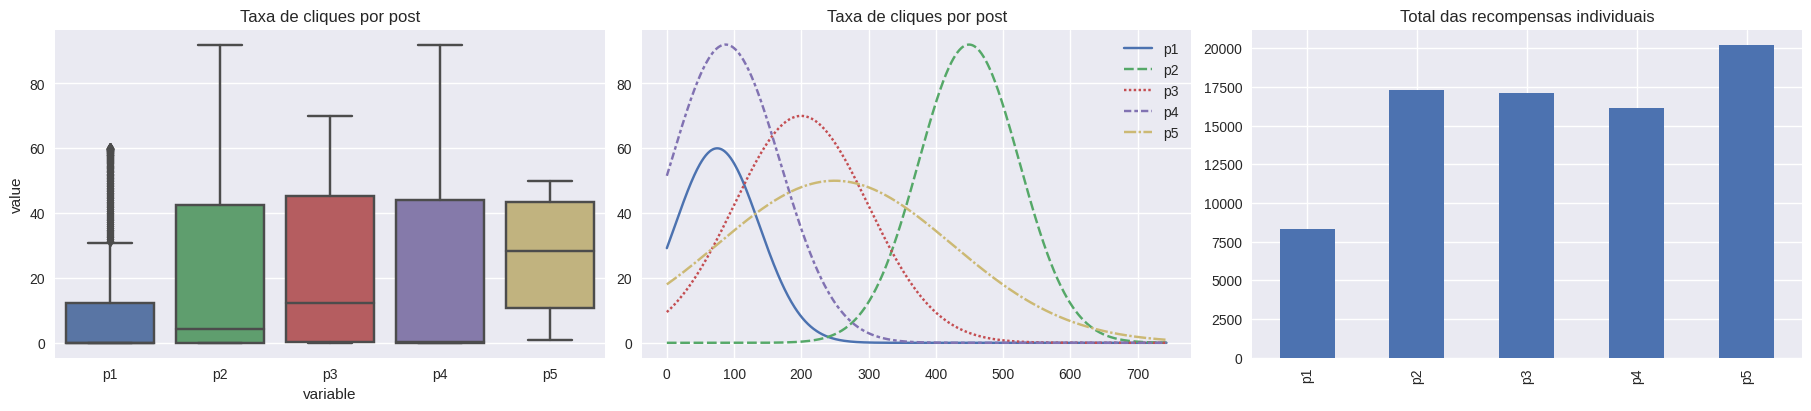

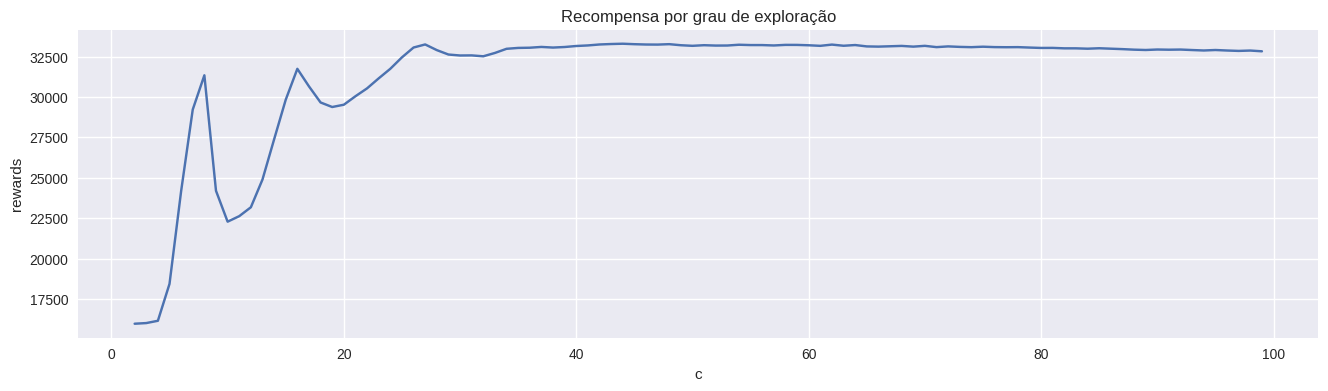

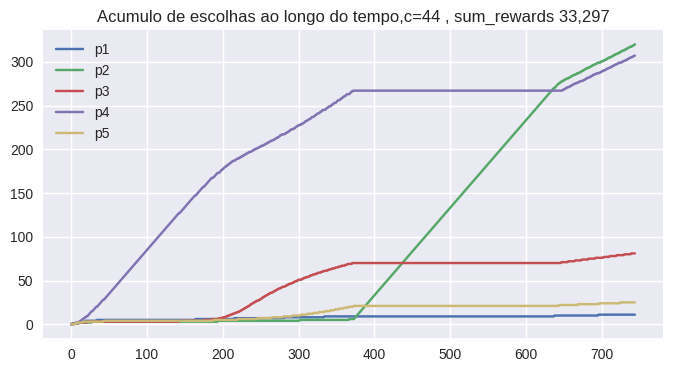

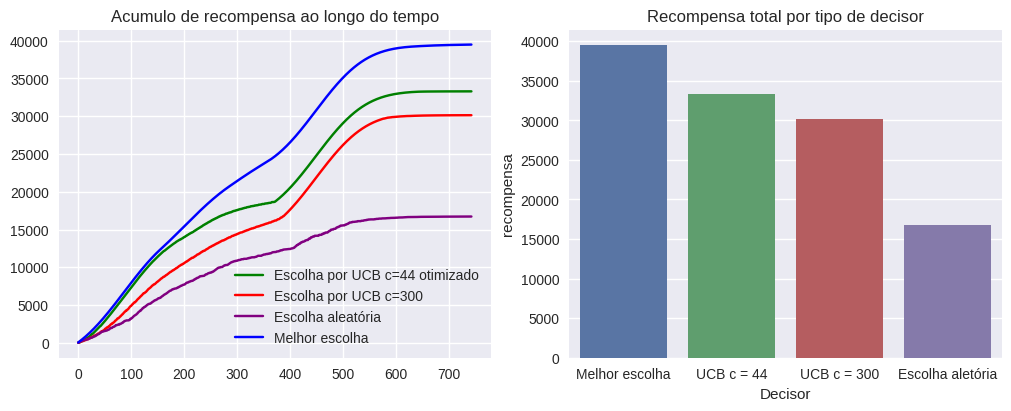

In [14]:
import numpy as np
from scipy.stats import norm

def create_normal_distribution_list(n_values=100, peak_value=50, start_increase=10, end_decrease=90):
    x = np.linspace(0, n_values, n_values)
    # Normal distribution parameters
    mean = (start_increase + end_decrease) / 2
    std_dev = (end_decrease - start_increase) / 4  # Adjust this value to change the "width" of the bell curve
    y = norm.pdf(x, mean, std_dev)
    y = y / np.max(y) * peak_value  # Normalize y to peak_value
    y = y.tolist()
    # y2 = reverse(y)
    return y

dias = 31
horas = 24*dias
# Crie a lista usando a função create_normal_distribution_list
p1 = create_normal_distribution_list(n_values=horas, peak_value=60, start_increase=-50, end_decrease=200)
p2 = create_normal_distribution_list(n_values=horas, peak_value=92, start_increase=300, end_decrease=600)
p3 = create_normal_distribution_list(n_values=horas, peak_value=70, start_increase=0, end_decrease=400)
p4 = create_normal_distribution_list(n_values=horas, peak_value=92, start_increase=-75, end_decrease=250)
p5 = create_normal_distribution_list(n_values=horas, peak_value=50, start_increase=-100, end_decrease=600)

posts_rates_normais_curves = pd.DataFrame({"p1":p1,
                                "p2":p2,
                                "p3":p3,
                                "p4":p4,
                                "p5":p5})

posts_rates_normais_curves = round(posts_rates_normais_curves,3)
# Exibe estatísticas descritivas dos dados
display(posts_rates_normais_curves.describe())

# Cria gráficos para visualizar os dados
fig, (ax1, ax2 , ax3) = plt.subplots(ncols=3, constrained_layout=True, figsize=(18, 4))
ax1.set_title("Taxa de cliques por post")
sns.boxplot(x="variable", y="value", data=pd.melt(posts_rates_normais_curves), ax=ax1)
ax2.set_title("Taxa de cliques por post")
sns.lineplot(data=posts_rates_normais_curves, ax=ax2)
ax3 = posts_rates_normais_curves.sum().plot(kind='bar',title='Total das recompensas individuais')
fig.show()

####################################

rewards = list()
for i in range(2,100):
  _ ,ucb_choice = ucb(posts_rates_normais_curves, c=i)
  rewards.append(ucb_choice['reward'].sum())

optimize_exploration = pd.DataFrame({"c":range(2,100) ,"rewards":rewards})

fig2, ax  = plt.subplots(ncols=1, figsize=(16, 4))
ax = sns.lineplot(data=optimize_exploration , x="c" , y="rewards")
ax.set(title="Recompensa por grau de exploração")
fig2.show()
####################################

c = 44
historySelected ,hist_choice_rewards = ucb(posts_rates_normais_curves, c=c)
fig3, ax4  = plt.subplots(ncols=1, figsize=(8, 4))
historySelected.plot(ax=ax4)
ax4.set(title =f"Acumulo de escolhas ao longo do tempo,c={c} , sum_rewards {hist_choice_rewards['reward'].sum():,.0f}" )
fig3.show()



####################################


_ ,ucb_choice = ucb(posts_rates_normais_curves, c=c)
ucb_choice['cumulative_reward'] = ucb_choice['reward'].cumsum()
ucb_choice_reward  = ucb_choice['reward'].sum()


N = 300
_ ,ucb_choiceN = ucb(posts_rates_normais_curves, c=N)
ucb_choiceN['cumulative_reward'] = ucb_choiceN['reward'].cumsum()
ucb_choiceN_reward  = ucb_choiceN['reward'].sum()


ramdom_choice = escolher_coluna_aleatoriamente(posts_rates_normais_curves)
ramdom_choice['cumulative_reward'] = ramdom_choice['reward'].cumsum()
ramdom_choice_reward  = ramdom_choice['reward'].sum()

best_choice = escolher_coluna_maior_valor(posts_rates_normais_curves)
best_choice['cumulative_reward'] = best_choice['reward'].cumsum()
best_choice_reward  = best_choice['reward'].sum()

recompensas = pd.DataFrame({"Decisor":["UCB c = 44", f"UCB c = {N}", "Escolha aletória","Melhor escolha"],
                    "recompensa":[ucb_choice_reward ,ucb_choiceN_reward , ramdom_choice_reward,best_choice_reward]}).sort_values("recompensa",ascending=False)



########################################

fig4, (ax5, ax6) = plt.subplots(ncols=2, constrained_layout=True, figsize=(10, 4))

ucb_choice['cumulative_reward'].plot(label=f"Escolha por UCB c={c} otimizado", ax=ax5, color="green")
ucb_choiceN['cumulative_reward'].plot(label=f"Escolha por UCB c={N}", ax=ax5 , color="red")
ramdom_choice['cumulative_reward'].plot(label="Escolha aleatória", ax=ax5 , color="purple")
best_choice['cumulative_reward'].plot(label="Melhor escolha", ax=ax5 , color="blue")
# last_best_choice['cumulative_reward'].plot(label="Último melhor")
ax5.set(title=f"Acumulo de recompensa ao longo do tempo")
ax5.legend()

ax6 = sns.barplot(data=recompensas , x="Decisor" , y="recompensa")
ax6.set(title=f"Recompensa total por tipo de decisor")
fig4.show()

In [12]:
recompensas

,Decisor,recompensa
3,Melhor escolha,39490.65
0,UCB c = 44,33296.58
1,UCB c = 300,30138.43
2,Escolha aletória,15870.89


- [Upper Confidence Bound Algorithm in Reinforcement Learning](https://www.geeksforgeeks.org/upper-confidence-bound-algorithm-in-reinforcement-learning/)
- [Deep Upper Confidence Bound Algorithm for Contextual Bandit Ranking of Information Selection](https://arxiv.org/abs/2110.04127)
- [Multi-Armed Bandit Python Example using UCB](https://www.hackdeploy.com/multi-armed-bandit-python-example-using-ucb/)
- [The Upper Confidence Bound (UCB) Bandit Algorithm](https://towardsdatascience.com/the-upper-confidence-bound-ucb-bandit-algorithm-c05c2bf4c13f)
- [Bandit Algorithms for Website Optimization - John Myles White](https://www.amazon.com.br/Bandit-Algorithms-Website-Optimization-Myles/dp/1449341330/ref=sr_1_1?__mk_pt_BR=%C3%85M%C3%85%C5%BD%C3%95%C3%91&keywords=Bandit+Algorithms+for+Website+Optimization&qid=1702069639&sr=8-1&ufe=app_do%3Aamzn1.fos.6121c6c4-c969-43ae-92f7-cc248fc6181d)